In [17]:
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import sleep

#Contrast processing

We have
$$ E(u) = \int_{\Omega} \frac{1}{2}||u(x) - u_0(x)||^2 + \frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)||u(x)-u(y)||^2 dxdy.$$
To compute of gradient, we have that $\nabla E(u)$ on $u$ satisfies that
$$\frac{d}{dt} E(u + t\psi)|_{t=0} = \langle \nabla E(u), \psi\rangle \;\; \forall \psi \in C_{c}^\infty(\Omega⊂\mathbb{R}^2, \mathbb{R}^3)\mbox{(differentiable)}.$$
Now
\begin{eqnarray*}
    E(u + t\psi)
    & = & \int_{\Omega} \frac{1}{2}||(u + t\psi)(x) - u_0(x)||^2 + \frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)||(u + t\psi)(x)-(u + t\psi)(y)||^2 dxdy   \\
    & = &\frac{1}{2} \int_{\Omega}  ||(u+t\psi)(x)||^2-2\langle (u+t\psi)(x), u_0(x)\rangle +||u_0(x)||^2 \\
    &  &+\frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)\Big(||(u+t\psi)(x)||^2-2\langle (u+t\psi)(x), (u+t\psi)(y) \rangle + ||(u+t\psi)(y)||^2\Big) dxdy\\
    & = &\frac{1}{2} \int_{\Omega}  ||u(x)||^2+2\langle u(x), t\psi(x)\rangle +t^2||\psi(x)||^2 - 2\langle (u+t\psi)(x), u_0(x)\rangle + ||u_0(x)||^2\\
    &  &+\frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)\Big(||(u+t\psi)(x)||^2-2\langle (u+t\psi)(x), (u+t\psi)(y)+||(u+t\psi)(y)||^2\rangle \Big)dxdy\\
    & = &\frac{1}{2} \int_{\Omega}  ||u(x)||^2+2t\langle u(x), t\psi(x)\rangle +t^2||\psi(x)||^2 - 2\langle u(x), u_0(x)\rangle - 2t\langle \psi(x), u_0(x)\rangle + ||u_0(x)||^2\\
     &  &+\frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)\Big(||u(x)||^2+2\langle u(x), \psi(x)\rangle+t^2||\psi(x)||^2+||u(y)||^2+2\langle \psi(y),  \psi(y)\rangle+t^2||\psi(y)||^2\\
     & &-2\langle u(x), u(y)\rangle -2t\langle u(x), \psi(y)\rangle -2t\langle \psi(x), u(y)\rangle -2t^2\langle \psi(x), \psi(y)\rangle \Big)\Big)dxdy
\end{eqnarray*}
By Fubini Theorem and the bilinearity of inner product, we have the next
\begin{eqnarray*}
    \frac{d}{dt} E(u + t\psi)|_{t=0} & = & \frac{1}{2} \int_{\Omega}  2\langle u(x), \psi(x)\rangle -2 \langle \psi(x), u_0(x)\rangle +\frac{\gamma}{4}\int_{\Omega}\int_{\Omega} w(x-y)\Big(2(\langle u(x), \psi(x)\rangle-\langle u(y), \psi(x)\rangle+\\
    & &\langle u(y), \psi(y)\rangle-\langle u(x), \psi(y)\rangle)\Big)dxdy\\
    & = & \int_{\Omega}  \langle u(x)-u_0(x), \psi(x)\rangle+\\
    & &\frac{\gamma }{2}\left( \int _\Omega \langle  \int _\Omega w(x-y) u(x), \psi(x)dy\rangle dx -  \int_\Omega \langle \int _\Omega w(x-y)u(x)dy,\psi(x)\rangle dx  + \int_\Omega  \langle \int _\Omega w(x-y)u(y)dx,\psi(y)\rangle dy  - \int_\Omega \langle \int _\Omega w(x-y)u(y)dx , \psi(y) \rangle dy \right)\\
    & = & \int_{\Omega}  \langle u(x)-u_0(x), \psi(x)\rangle+\\
    & &\frac{\gamma }{2}\left( \int _\Omega \langle u(x), \psi(x)\rangle dx -  \int_\Omega \langle w*u(x),\psi(x)\rangle dx  + \int_\Omega  \langle u(y),\psi(y)\rangle dy  - \int_\Omega \langle w*u(y) , \psi(y) \rangle dy \right)\\
   & = & \int_{\Omega}  \langle u(x)-u_0(x), \psi(x)\rangle + \int _\Omega \langle u(x)- w*u(x) , \phi(x)\rangle dx.
\end{eqnarray*}
In conclusion
$$ \nabla E(u) = u-u_0 - \gamma(u - w * u)$$
where $\ast$ stands for the component-wise convolution and $w$ is a normalized Gaussian kernel of standard deviation $σ$.
Applying the gradient descent algorithm associated to the previously functional in order to enhance simultaneously the details and the global contrast of img2.png

In [18]:
def fast_gaussian_convolution(u,sigma):

	gaussian_kernel_1d_1 = np.expand_dims(signal.gaussian(u.shape[0],sigma),axis=1)
	gaussian_kernel_1d_2 = np.expand_dims(signal.gaussian(u.shape[1],sigma),axis=1)
	gaussian_kernel_2d = np.matmul(gaussian_kernel_1d_1,np.transpose(gaussian_kernel_1d_2))
	gaussian_kernel_2d = gaussian_kernel_2d/np.sum(gaussian_kernel_2d)

	return np.real(np.fft.fftshift(np.fft.ifft2(np.fft.fft2(u)*np.fft.fft2(gaussian_kernel_2d))))

In [19]:
def RGBtoOPP(img):
  to =  np.array( [ [1/np.sqrt(3),1/np.sqrt(2),1/np.sqrt(6)],
                    [1/np.sqrt(3), -1/np.sqrt(2), 1/np.sqrt(6)],
                    [1/np.sqrt(3),0,-2/np.sqrt(6)] ] )
  orgb = np.zeros_like(img).astype(np.float32)
  invto = to.T
  i=0
  for row in invto:
    orgb[:,:,i]=row[0]*img[:,:,0]+row[1]*img[:,:,1]+row[2]*img[:,:,2]
    i+=1
  return orgb

In [20]:
def OPPtoRGB(img):
  to =  np.array( [ [1/np.sqrt(3),1/np.sqrt(2),1/np.sqrt(6)],
                    [1/np.sqrt(3), -1/np.sqrt(2), 1/np.sqrt(6)],
                    [1/np.sqrt(3),0,-2/np.sqrt(6)] ] )
  rgb = np.zeros_like(img).astype(np.float32)
  i=0
  for row in to:
    rgb[:,:,i]=row[0]*img[:,:,0]+row[1]*img[:,:,1]+row[2]*img[:,:,2]
    i+=1
  return rgb

In [21]:
def MSE(u, v):
    sqErr  = np.square(u - v)
    mSqErr = sqErr.mean()

    return np.sqrt(mSqErr)

In [105]:
def decendentgrad(img,alpha,gamma,sigma,eps,K,name):
    u0     =  img[:,:,0]
    u01    =  img[:,:,1]
    u02    =  img[:,:,2]
    uprev  =  np.copy(u0).astype(np.float32)
    uprev1 =  np.copy(u01).astype(np.float32)
    uprev2 =  np.copy(u01).astype(np.float32)
    unext  =  np.zeros_like(uprev).astype(np.float32)
    unext1 =  np.zeros_like(uprev1).astype(np.float32)
    unext2 =  np.zeros_like(uprev1).astype(np.float32)
    err    =  np.inf
    err1   =  np.inf
    err2   =  np.inf
    k      =  0

    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    out = cv2.VideoWriter(name, fourcc, 20.0, (img.shape[1],  img.shape[0]))

    while k < K:
        unext = uprev - alpha[0]*( (uprev - u0) - gamma[0]*( uprev - fast_gaussian_convolution(uprev,sigma[0]) ) )
        unext1 = uprev1 - alpha[1]*( (uprev1 - u01) - gamma[1]*( uprev1 - fast_gaussian_convolution(uprev1,sigma[1]) ) )
        unext2 = uprev2 - alpha[1]*( (uprev2 - u02) - gamma[1]*( uprev2 - fast_gaussian_convolution(uprev2,sigma[1]) ) )
        err = MSE(unext, uprev)
        err1= MSE(unext1, uprev1)
        err2 = MSE(unext2, uprev2)
        uprev = np.copy(unext)
        uprev1 = np.copy(unext1)
        uprev2 = np.copy(unext2)
        k    += 1
        frame = np.zeros_like(img).astype(np.float32)
        frame[:,:,0] = unext
        frame[:,:,1] = unext1
        frame[:,:,2] = unext2
        frame = np.clip(OPPtoRGB(frame),0,255).astype(np.uint8)
        frame = cv2.rectangle(frame, (0, 0), (70+12*len(str(k)), 15), (45,232,101), -1)
        frame = cv2.putText(frame, "Iterations: "+str(k), (0, 10), 1, 0.75,
                        (255, 255, 255 ), 2)
        out.write(frame)
        sleep(2)
        if err < eps and err1 < eps and err2 < eps:
          break


    print("Error: ",err,"Iteraciones:",k)
    out.release()
    cv2.destroyAllWindows()
    return frame

Testing on the image.

In [110]:
img = cv2.imread("img2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [111]:
oppimg =  RGBtoOPP(img)

In [112]:
k = 15000
imgrestored = []
alpha = [0.01,0.01]
gamma = [0.5,0.75]
sigma = [5,3000]
name = "animation.mp4"
imgf = decendentgrad(oppimg, alpha, gamma, sigma, 0.001, k, name)

Error:  1.0495905978898057e-05 Iteraciones: 1870


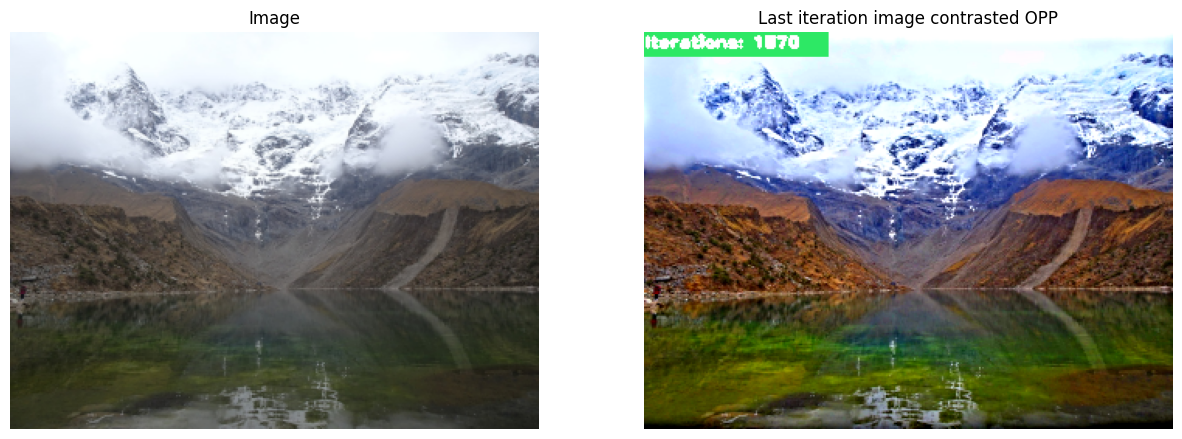

In [113]:
figure(figsize=(15,15), dpi=100)
plt.subplot(121), plt.imshow(img), plt.title('Image')
plt.axis('off')
plt.subplot(122), plt.imshow(imgf), plt.title('Last iteration image contrasted OPP')
plt.axis('off')
plt.show()